Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). On JupyterLab, you may want to hit the "Validate" button as well.

Caution: do not mess with the notebook's metadata; do not change a pre-existing cell's type; do not copy pre-existing cells (add new ones with the + button instead). This will break autograding; you will get a 0; you are warned.

<table style="width: 100%; border: none;" cellspacing="0" cellpadding="0" border="0">
  <tr>
    <td><img src="https://www.planetegrandesecoles.com/wp-content/uploads/2021/07/Identite%CC%81-visuelle-Plane%CC%80te-BAC-8-600x398.png" style="float: left; width: 100%" />
</td>
    <td><a style="font-size: 3em; text-align: center; vertical-align: middle;" href="https://moodle.polytechnique.fr/course/view.php?id=19260">[CSC2S004EP - 2024] - Introduction to Machine Learning</a>
</td>
  </tr>
</table>

<a style="font-size: 3em;">Lab Session 2: parametric models</a>

Jérémie DECOCK - Adrien EHRHARDT

# Objectives

- Introduction to parametric models for regression: we assume a particular form in the relationship of $\boldsymbol{x}$ to $y$.
- Calculate by hand a linear regression: what is the "closest line" to my data points?
- Implement a linear regressor using gradient descent: implement a method so as to make the computer iteratively find that "closest line".
- Linear regression with Scikit Learn: there's a catch -> "someone" already did that (obviously)!
- Implement a polynomial regressor with Scikit Learn: that "someone" implemented even cleverer methods.

# Imports and tool functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import axes3d

import sklearn
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing

**Read carefully** the function definitions below (especially the two first ones); we'll use them to generate and plot some data which will be the subject of subsequent questions.

## Generate some fake data

In [2]:
def gen_1d_linear_regression_samples(n_samples: int = 20) -> pd.DataFrame:
    """
    Generate one-dimensional linear regression samples

    :param int n_samples: number of samples to generate
    """
    x = np.random.uniform(low=-8., high=8., size=n_samples)
    y = 2. * x - 3. + np.random.normal(scale=1.5, size=x.shape)
    df = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
    df = sklearn.utils.shuffle(df).reset_index(drop=True)
    return df


def gen_1d_polynomial_regression_samples(n_samples: int = 15) -> pd.DataFrame:
    """
    Generate one-dimensional polynomial regression samples

    :param int n_samples: number of samples to generate
    """
    x = np.random.uniform(low=-5., high=5., size=n_samples)
    y = -4. + 2 * x + 0.7 * x ** 2 - 1.5 * x ** 3 + np.random.normal(scale=8., size=x.shape)
    df = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
    df = sklearn.utils.shuffle(df).reset_index(drop=True)
    return df

## Plotting functions

In [3]:
def plot_XY(X: np.array, y: np.array):
    """
    Puts X and y in a dataframe and plot the result; expects one-dimensional inputs X and y.
    If theta_0 and theta_1 are provided, calculate and plot y_hat as well.

    :param numpy.array X: one-dimensional regression feature
    :param numpy.array y: one-dimensional target feature
    """
    df = pd.DataFrame(np.array([X, y]).T, columns=['x', 'y'])
    ax = df.plot.scatter(x="x", y="y")
    return ax


def plot_1d_regression_samples(dataframe: pd.DataFrame, model=None):
    """
    Plot the regression samples in one-D with the predictions if model is provided

    :param pandas.DataFrame dataframe: a dataframe containing the :code:`x` feature and
        :code:`y` dependent feature to regress on.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    df = dataframe.copy()  # make an alias

    ERROR_MSG1 = "The `dataframe` parameter should be a Pandas DataFrame having the following columns: ['x', 'y']"
    assert df.columns.values.tolist() == ['x', 'y'], ERROR_MSG1

    if model is not None:
        # Compute the model's prediction
        x_pred = np.linspace(df.x.min(), df.x.max(), 100).reshape(-1, 1)
        y_pred = model.predict(pd.DataFrame(x_pred, columns=['x']))
        df_pred = pd.DataFrame(np.array([x_pred.flatten(), y_pred.flatten()]).T, columns=['x', 'y'])
        df_pred.plot(x='x', y='y', style='r--', ax=ax)

    # Plot also the training points
    df.plot.scatter(x='x', y='y', ax=ax)
    delta_y = df.y.max() - df.y.min()
    plt.ylim((df.y.min() - 0.15 * delta_y,
              df.y.max() + 0.15 * delta_y))


def plot_ex4(X: np.array, y: np.array, theta_1: float = None, theta_2: float = None):
    """
    Puts X and y in a dataframe and plot the result; expects one-dimensional inputs X and y.
    If theta_1 and theta_2 are provided, calculate and plot y_hat = theta_1 * x + theta_2 * x**2 as well.

    :param numpy.array X: one-dimensional regression feature
    :param numpy.array y: one-dimensional target feature
    :param float theta_1: linear regression coefficient associated with X
    :param float theta_2: linear regression coefficient associated with X**2
    """
    ax = plot_XY(X, y)

    if theta_1 is not None and theta_2 is not None:
        x = np.linspace(0, 6, 50)
        y = theta_1 * x + theta_2 * x**2
        ax.plot(x, y, "--r")

# Introduction

Today you will learn to solve *regression* problems using **parametric models** (the application of parametric models to *classification* problems will be the subject of another session): you will use a parametric function $f_{\boldsymbol{\theta}}: \boldsymbol{x} \mapsto y$ to infer the link existing between input vectors $\boldsymbol{x} \in \mathbb{R}^p$ and output values $y \in \mathbb{R}$ in a *learning set* $\mathcal{D} = \{(\boldsymbol{x^{(i)}}, y^{(i)})\}_{1 \leq i \leq n}$ of $n$ examples.

The *hypothesis space* $\mathcal{H}$ of $f_{\boldsymbol{\theta}}$ is chosen *a priori*, so that the model fits reasonably well the data in $\mathcal{D}$. For instance, $\mathcal{H}$ can be the space of linear functions if the data seems to be distributed along a line in $\mathcal{D}$. The space of polynomial functions of degree $d>1$ may be a good choice otherwise.

The parameter $\boldsymbol{\theta}^* = \begin{pmatrix} \theta_0^* & \dots & \theta_p^* \end{pmatrix}^T$ is then searched to obtain the best fit between $f_{\boldsymbol{\theta}}$ and $\mathcal{D}$. This is an optimization problem.

For instance, assume you have chosen the space of linear functions to make a model that describes the data in $\mathcal{D}$, and $p=1$ (one-dimensional regression).

Your model is then $y = \theta_0 + \theta_1 x$ and the regression problem consists in finding the best parameters (strictly speaking, estimators of these parameters) $\theta_0^\star$ and $\theta_1^\star$ for it.

**Note**: there are some differences in notations with the lecture slides: parameters are noted $w$ (for "weights": machine learning community) in lectures but they are noted $\theta$ (for parameters: statistics community) here.

# Linear regression: an analytic definition of the optimal parameters

We have a *learning set* $\mathcal{D} = \{(\boldsymbol{x^{(i)}}, y^{(i)})\}_{1 \leq i \leq n}$.

We assume:
- Errors (difference between actual labels $y$ and predicted labels $\hat{y} = f_{\theta}(\boldsymbol{x})$) are gaussian random values centered at 0: $y = f_{\boldsymbol{\theta}}(\boldsymbol{x}) + \epsilon$ with $\epsilon \sim \mathcal{N}(0, \sigma^2)$.
- Data is modeled with a linear function: $f_{\boldsymbol{\theta}}(\boldsymbol{x}) = \theta_0 + \sum_{j=1}^p \theta_j \boldsymbol{x}_j = (1 \; x)^T \boldsymbol{\theta}$.

- Observations $\boldsymbol{x} \in \mathbb{R}^p$ can be defined as $p$ random values $X_1, X_2, \dots, X_p$
- Labels $y$ are then realizations of a random value $Y$ such that:

$$Y \sim \mathcal{N}(\underbrace{f(\boldsymbol{x} | \boldsymbol{\theta})}_{\mu}, \sigma^2)$$

We want to find the estimator $\boldsymbol{\theta}^* = \begin{pmatrix} \theta_0^* & \dots & \theta_p^* \end{pmatrix}^T$ that gives the best fit between $f_{\boldsymbol{\theta}}$ and $\mathcal{D}$ (optimization problem).

Finding the best $\boldsymbol{\theta}^*$ is a maximum likelihood problem : $\boldsymbol{\theta}^* \leftarrow {\arg\!\max}_{\boldsymbol{\theta}} \mathbb{P}(\mathcal{D}|\boldsymbol{\theta})$.
Here, it is equivalent to apply the method of *least squares* or to minimize the Mean Square Error (MSE).
Using matrix notation, we define the linear regression problem as:

$$\boldsymbol{\theta}^* \leftarrow {\arg\!\min}_{\boldsymbol{\theta}} E(\boldsymbol{\theta}) \quad \text{with} \quad E(\boldsymbol{\theta}) = (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})^T(\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})$$

and

$$
\boldsymbol{X} = \begin{pmatrix} 1 & x_1^{(1)} & \dots & x_p^{(1)} \\ \vdots & \vdots & \dots & \vdots \\ 1 & x_1^{(n)} & \dots & x_p^{(n)} \end{pmatrix}
\quad \quad
\boldsymbol{y} = \begin{pmatrix} y^{(1)} \\ \vdots \\ y^{(n)} \end{pmatrix}
\quad \quad
\boldsymbol{\theta} = \begin{pmatrix} \theta_0 \\ \vdots \\ \theta_p \end{pmatrix}.
$$

$E(\boldsymbol{\theta})$ is a quadratic form (convex function) thus it has a unique global minimum $\boldsymbol{\theta^*}$ where $\nabla_{\boldsymbol{\theta^*}} E(\boldsymbol{\theta^*}) = \boldsymbol{0}$

## Exercise 1 - the theory

In the cell below or on a sheet of paper that you can insert as image (New Cell > Markdown > Edit > Insert Image):
- Compute the analytic formulation of the gradient $\nabla_{\boldsymbol{\theta}} E(\boldsymbol{\theta})$ of the residual sum of squares $E(\boldsymbol{\theta}) = (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})^T(\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})$
- Compute the analytic formulation of the optimal parameter $\boldsymbol{\theta^*}$

You can first use $p=1$, but with a greater value of $p$, matrix notation (and calculus) will come in handy.

You may use your lecture notes, but do not copy-paste blindly; this exercise is here for you as it's important to remember these things.

Recall about matrices:

$$
(\boldsymbol{A} + \boldsymbol{B})^T = \boldsymbol{A}^T + \boldsymbol{B}^T
$$

$$
(\boldsymbol{A} \boldsymbol{B})^T = \boldsymbol{B}^T \boldsymbol{A}^T
$$

\begin{align}
\text{Associativity:} & \quad
(\boldsymbol{A} \boldsymbol{B}) \boldsymbol{C}
= \boldsymbol{A} (\boldsymbol{B} \boldsymbol{C})
= \boldsymbol{A} \boldsymbol{B} \boldsymbol{C}
\\
\text{Non-commutativity:} & \quad
\boldsymbol{A} \boldsymbol{B}
\neq \boldsymbol{B} \boldsymbol{A}
\\
\text{Distributivity:} & \quad
\boldsymbol{A} (\boldsymbol{B} + \boldsymbol{C})
= \boldsymbol{A} \boldsymbol{B} + \boldsymbol{A} \boldsymbol{C} \\
& \quad
(\boldsymbol{B} + \boldsymbol{C}) \boldsymbol{A} 
= \boldsymbol{B} \boldsymbol{A} + \boldsymbol{C} \boldsymbol{A}
\end{align}

Recall about matrix differentiation:

\begin{align}
d(\boldsymbol{A}) & = 0  \quad \quad \quad \text{if } \boldsymbol{A} \text{ is not function of } \boldsymbol{X} \\
d(a\boldsymbol{X}) & = a d \boldsymbol{X}  \quad \quad \text{if } a \text{ is not function of } \boldsymbol{X} \\
d(\boldsymbol{X} +\boldsymbol{Y}) & = d \boldsymbol{X} + d \boldsymbol{Y} \\
d(\boldsymbol{XY}) & = (d \boldsymbol{X}) \boldsymbol{Y} + \boldsymbol{X} (d \boldsymbol{Y}) \\
d(\boldsymbol{X}^T) & = (d \boldsymbol{X})^T \\
\end{align}

YOUR ANSWER HERE

The residual sum of squares is given by 
$
E(\boldsymbol{\theta}) = (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})^T (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})
$
which expands to 
$
E(\boldsymbol{\theta}) = \boldsymbol{y}^T \boldsymbol{y} - 2 \boldsymbol{y}^T \boldsymbol{X} \boldsymbol{\theta} + \boldsymbol{\theta}^T \boldsymbol{X}^T \boldsymbol{X} \boldsymbol{\theta}.
$

Differentiating with respect to $ \boldsymbol{\theta} $ and setting the gradient to zero, we obtain $ \nabla_{\boldsymbol{\theta}} E(\boldsymbol{\theta}) = -2 \boldsymbol{X}^T \boldsymbol{y} + 2 \boldsymbol{X}^T \boldsymbol{X} \boldsymbol{\theta} = 0,
$

which simplifies to the normal equation $
\boldsymbol{X}^T \boldsymbol{X} \boldsymbol{\theta} = \boldsymbol{X}^T \boldsymbol{y}.
$

Solving for $ \boldsymbol{\theta} $, we get the optimal parameters as $
\boldsymbol{\theta}^* = (\boldsymbol{X}^T \boldsymbol{X})^{-1} \boldsymbol{X}^T \boldsymbol{y},
$ which is the closed-form solution for ordinary least squares regression.


## Exercise 2 - an example

### Question 1

Use the previous equations to compute **by hand** (*i.e.* in the cell below or on a sheet of paper that you paste below - New Cell > Markdown > Edit > Insert Image) the optimal parameters $\theta_0$ and $\theta_1$ of the model $y = \theta_0 + \theta_1 x$ to best fit the following dataset (of four observations):

$$\mathcal{D} = \left\{
\begin{pmatrix} 1 \\ 1 \end{pmatrix},
\begin{pmatrix} 4 \\ 2 \end{pmatrix},
\begin{pmatrix} 8 \\ 3 \end{pmatrix},
\begin{pmatrix} 15 \\ 4 \end{pmatrix}
\right\}$$

This will require [inverting a 2x2 matrix](https://www.chilimath.com/lessons/advanced-algebra/inverse-of-a-2x2-matrix/).

Recall that for a 2x2 matrix the inverse is:

$\begin{pmatrix} a & b \\ c & d \end{pmatrix}^{-1} = \frac{1}{ad-bc} \begin{pmatrix} d & -b \\ -c & a \end{pmatrix}$

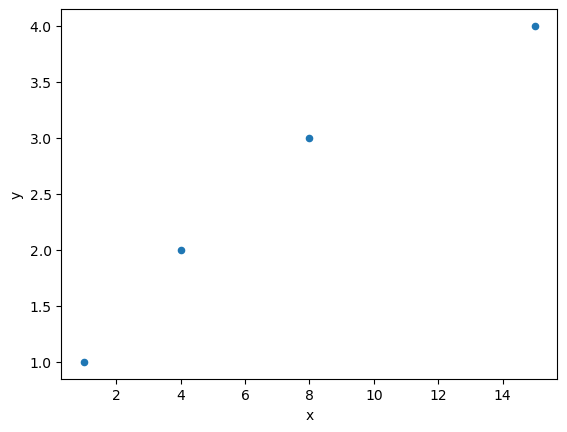

In [4]:
X = [1, 4, 8, 15]
y = [1, 2, 3, 4]

plot_XY(X, y);  # see in above how this is plotted

YOUR ANSWER HERE

Computation of $\boldsymbol{\theta}^*$ to get $\theta_0$ and $\theta_1$ :

$
X = \begin{pmatrix} 
1 & 1 \\ 
1 & 4 \\
1 & 8 \\
1 & 15
\end{pmatrix}
$ and $y = \begin{pmatrix} 
1 \\ 
2 \\
3 \\
4 
\end{pmatrix}
$

$
X^T = \begin{pmatrix} 
1 & 1 & 1 & 1 \\ 
1 & 4 & 8 & 15
\end{pmatrix}
$ 

$
X^T X = \begin{pmatrix} 
4 & 28 \\ 
28 & 306 
\end{pmatrix}
$

$
(X^T X)^{-1} = \frac{1}{440} \begin{pmatrix} 
306 & -28\\ 
-28 & 4
\end{pmatrix}
$

$
X^T y = \begin{pmatrix} 
10 \\ 
93
\end{pmatrix}
$

$
\boldsymbol{\theta}^* = (X^T X)^{-1} X^T y = \begin{pmatrix} 
\frac{57}{55} \\ 
\frac{23}{110}
\end{pmatrix}
$

Hence we find that $\theta_0 = \frac{57}{55}$ and   $\theta_1 = \frac{23}{110}$ 


### Question 2

Check graphically that the model you obtained fits the data well using the following cell (uncomment and complete the first two lines and uncomment the last one).

In [5]:
def plot_q2(X: np.array, y: np.array, theta_0: float = None, theta_1: float = None):
    """
    Puts X and y in a dataframe and plot the result; expects one-dimensional inputs X and y.
    If theta_0 and theta_1 are provided, calculate and plot y_hat as well.

    :param numpy.array X: one-dimensional regression feature
    :param numpy.array y: one-dimensional target feature
    :param float theta_0: constant linear regression coefficient
    :param float theta_1: linear regression coefficient associated with X
    """
    ax = plot_XY(X, y)

    if theta_0 is not None and theta_1 is not None:
        x = np.array([1, 15])
        y = theta_0 + theta_1 * x
        ax.plot(x, y, "--r")

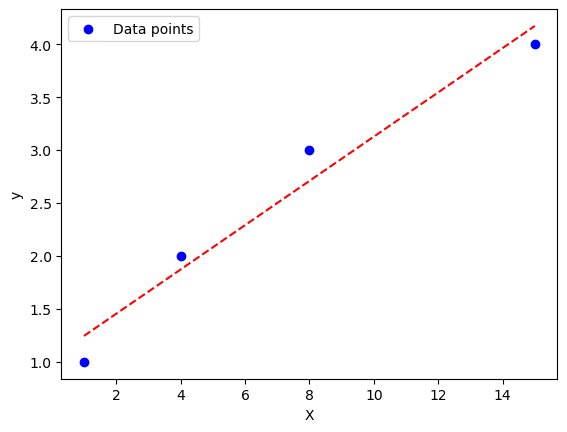

In [6]:
# DO NOT ROUND OFF THE PREVIOUSLY CALCULATED VALUES
theta_0 = 57/55  # <- TO UNCOMMENT AND TO COMPLETE (intercept)
theta_1 = 23/110  # <- TO UNCOMMENT AND TO COMPLETE (slope)

# YOUR CODE HERE
def plot_XY(X, y):
    """Plots the given data points."""
    fig, ax = plt.subplots()
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.scatter(X, y, color='blue', label="Data points")
    ax.legend(loc="upper left")
    return ax

plot_q2(X, y, theta_0, theta_1)  # see above how this is plotted

In [7]:
assert theta_0 == 57. / 55.

### Question 3

Plot the MSE $E(\boldsymbol{\theta})$ with the following cells.
What is plotted? What is the input space and the output space?

What can you say about these plots?

In [8]:
# Let's put X, y (lists) in arrays
X = np.array([[1, 1, 1, 1], X]).T
y = np.array(y).reshape(-1, 1)

In [9]:
X

array([[ 1,  1],
       [ 1,  4],
       [ 1,  8],
       [ 1, 15]])

In [10]:
y

array([[1],
       [2],
       [3],
       [4]])

In [11]:
def plot_contour_2d_solution_space(
    func, fig=None, ax=None, theta_min: np.array = None, theta_max: np.array = None,
    theta_star: np.array = None, theta_visited: np.array = None, title: str = ""):
    """
    Plot points visited during the execution of an optimization algorithm.
    """
    if (fig is None) or (ax is None):
        fig, ax = plt.subplots(figsize=(12, 8))

    # Define limits of the plot
    if theta_visited is not None:
        if theta_min is None or theta_max is None:
            theta_min = np.min(theta_visited, axis=0) - 2
            theta_max = np.max(theta_visited, axis=0) + 2
        if theta_star is not None:
            theta_min = np.minimum(theta_min, theta_star.T)[0] - 2
            theta_max = np.maximum(theta_max, theta_star.T)[0] + 2

        theta_min = np.amin(np.hstack([theta_min.reshape([-1, 1]), theta_visited.T]), axis=1)
        theta_max = np.amax(np.hstack([theta_max.reshape([-1, 1]), theta_visited.T]), axis=1)

    x1_space = np.linspace(theta_min[0], theta_max[0], 200)
    x2_space = np.linspace(theta_min[1], theta_max[1], 200)
    x1_mesh, x2_mesh = np.meshgrid(x1_space, x2_space)
    zz = func(np.array([x1_mesh.ravel(), x2_mesh.ravel()])).reshape(x1_mesh.shape)

    ############################

    # Define points of minimum and maximum of func within these limits
    if theta_star is not None:
        min_value = func(theta_star)
    else:
        min_value = zz.min()
        
    max_value = zz.max()
    levels = np.logspace(0.1, 3., 5)
    # Plot area and output color given value of func
    im = ax.pcolormesh(x1_mesh,
                       x2_mesh,
                       zz,
                       vmin=min_value,
                       vmax=max_value,
                       shading='gouraud',
                       cmap='gnuplot2')

    plt.colorbar(im, ax=ax)

    cs = plt.contour(x1_mesh,
                     x2_mesh,
                     zz,
                     levels,
                     linewidths=(2, 2, 2, 2, 3),
                     linestyles=('dotted', '-.', 'dashed', 'solid', 'solid'),
                     alpha=0.5,
                     colors='white')
    ax.clabel(cs, inline=False, fontsize=12)

    ############################

    # Add visited theta to the plot during gradient descent
    if theta_visited is not None:
        ax.plot(theta_visited.T[0],
                theta_visited.T[1],
                '-og',
                alpha=0.5,
                label="$visited$")

    ############################

    # Add theta_star as a point to the plot. N.B.: it should lie at the minimum of func!
    if theta_star is not None:
        sc = ax.scatter(theta_star[0],
                        theta_star[1],
                        c='red',
                        label=r"$\theta^*$")
        sc.set_zorder(10)  # put this point above every thing else

    ############################

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(r"$\theta_0$", fontsize=16)
    ax.set_ylabel(r"$\theta_1$", fontsize=16)
    ax.legend(fontsize=16)

    return fig, ax

In [12]:
class MSE:
    """This class computes mean-squared-error of E(theta) given initial X, y."""
    def __init__(self, X, y):
        """Use always the same X, y. N.B.: __init__ is the method called when instanciating a new object of this class."""
        self.X = np.copy(X)
        self.y = np.copy(y)
        
    def __call__(self, theta):
        """Compute E(\theta). N.B.: __call__ is the method called when using parentheses () on an existing object of this class,
        i.e. acts as a function call."""
        return ((np.tile(self.y, theta.shape[1]) - np.dot(self.X, theta))**2).sum(axis=0)

In [13]:
mse = MSE(X, y)

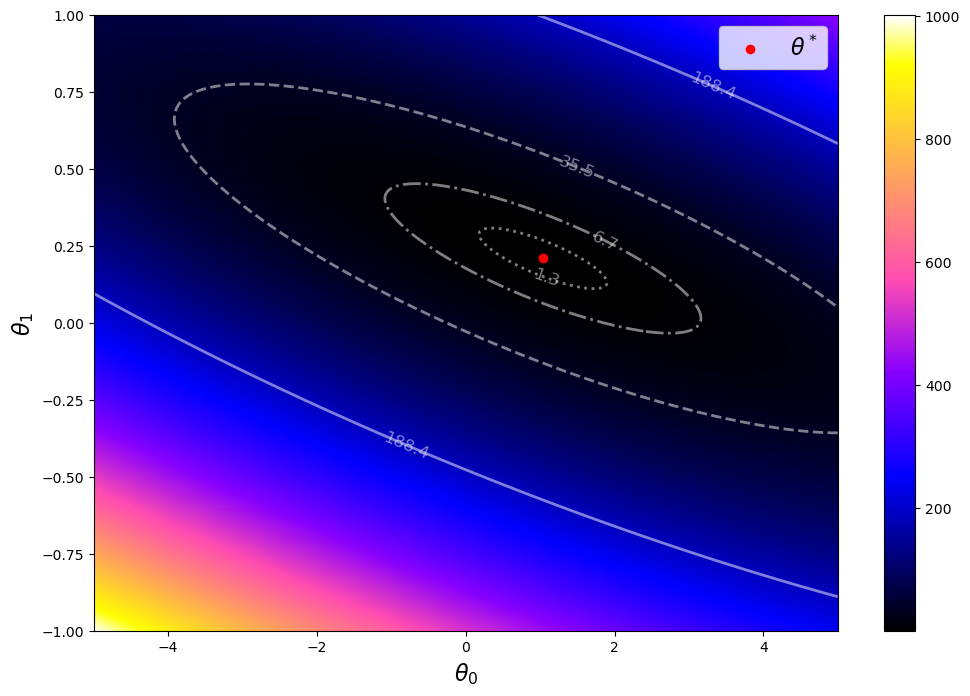

In [14]:
# see above how this is plotted
plot_contour_2d_solution_space(func=mse,
                               theta_min=np.array([-5, -1]),
                               theta_max=np.array([5, 1]),
                               theta_star=np.array([[theta_0], [theta_1]]));

N.B.: a global qualitative answer is expected in the next cell.

YOUR ANSWER HERE


This plot shows how the error changes with different values of $\theta_0$ and $\theta_1$.
The contour lines around the red dot are close together, meaning the error increases quickly if we move away from this point. 
The colors also show the error with the darkest colors meaning a low error and the lightest colors meaning a high error.

The red dot $\theta^*$ is in the darkest area, meaning it has the lowest error which means we found the best value for the model.


## Linear regression: an approximated solution using a *gradient descent* method

When $(X^TX)^{-1}$ cannot be easily computed (e.g. no analytical solution or $\mathcal{D}$ contains a lot of examples or the dimension of the solution space $\mathcal{X}$ is too large), an approximated solution can be computed using a *gradient descent method*.

Also, we'll use *gradient descent* for other models than linear regression, so this will serve as an introduction.

$\nabla_{\boldsymbol{\theta}}E(\hat{\boldsymbol{\theta}})$ gives the direction of the largest slope at the point $\hat{\theta}$.
Thus, if we explore iteratively the parameter space by following the opposite direction of this gradient as described in the following definition, we should converge to the parameter $\boldsymbol{\theta}^\star$ that minimizes the MSE, i.e. the parameter $\boldsymbol{\theta}^\star$ such that $\nabla_{\boldsymbol{\theta}^\star}E({\boldsymbol{\theta}^\star}) = 0$.

Starting from a random point $\boldsymbol{\theta}$, the gradient descent method proposes a new point 
$\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \eta \nabla_{\boldsymbol{\theta}}E(\boldsymbol{\theta})$ at each iteration until a stopping criterion has been reached: e.g. $||\nabla_{\boldsymbol{\theta}}E(\boldsymbol{\theta})||_2^2 < \epsilon$ with $\epsilon$ a chosen minimal length for the gradient to continue iterations.

The *learning rate* $\eta \in \mathbb{R}_+^*$ is a parameter to tweak for the considered problem.
- If $\eta$ is too large, the optimization may not converge toward 0.
- If $\eta$ is too small, the optimization may require a lot of iterations to converge.

### Exercise 3

#### Question 1

Recall our 4 points in one-dimension, which were our earlier dataset example:

In [15]:
X

array([[ 1,  1],
       [ 1,  4],
       [ 1,  8],
       [ 1, 15]])

In [16]:
y

array([[1],
       [2],
       [3],
       [4]])

Calculate by hand (in the cell below or on a sheet of paper that you can insert as image (New Cell > Markdown > Edit > Insert Image)) the expression of the gradient $\nabla_{\boldsymbol{\theta}}E(\boldsymbol{\theta}) = \begin{pmatrix} \nabla_{\boldsymbol{\theta}_0}E(\boldsymbol{\theta}) \\ \nabla_{\boldsymbol{\theta}_1}E(\boldsymbol{\theta}) \end{pmatrix}$.

YOUR ANSWER HERE

We have :
$\nabla_{\boldsymbol{\theta}} E(\boldsymbol{\theta}) = -2 \boldsymbol{X}^T \boldsymbol{y} + 2 \boldsymbol{X}^T \boldsymbol{X} \boldsymbol{\theta}
$

We substitute the values :

$
\nabla_{\theta} E(\theta) =
-2 \begin{pmatrix} 
10 \\ 
93
\end{pmatrix}
+2 \begin{pmatrix} 
4 & 28 \\ 
28 & 306 
\end{pmatrix}
\begin{pmatrix} 
\theta_0 \\ 
\theta_1 
\end{pmatrix}
$
$=$
$
\begin{pmatrix} 
8\theta_0 + 56\theta_1 - 20 \\ 
56\theta_0 + 612\theta_1 - 186
\end{pmatrix}
$

Therefore we obtain the partial derivatives : 

$
\nabla_{\boldsymbol{\theta}_0}E(\boldsymbol{\theta}) = \frac{\partial E}{\partial \theta_0} = 8\theta_0 + 56\theta_1 - 20
$

$
\nabla_{\boldsymbol{\theta}_1}E(\boldsymbol{\theta}) = \frac{\partial E}{\partial \theta_1} = 56\theta_0 + 612\theta_1 - 186
$

Implement a gradient descent method to solve exercise 2 with an approximated solution.
Use the analytic formulation of $\nabla_{\boldsymbol{\theta}}E(\boldsymbol{\theta})$ that has been computed in exercise 1.

You can use a very basic stopping criterion: the number of iterations (e.g. 10000).
You can start with $\eta = 0.001$.
See default parameters.

In [17]:
def gradient_descent(X: np.array, y: np.array, eta: float = 0.001, max_iteration: int = 10000, 
                     theta: np.array = np.random.normal(loc=0, scale=10, size=[2, 1])):
    """
    Perform linear regression by gradient descent

    :param numpy.array X: features (which should include a column of 1 if an intercept is to be fitted) - 2D
    :param numpy.array y: targets - 2D (but shape[1] is 1! A single column!)
    :param float eta: learning rate (the higher the faster the convergence but beware...)
    :param int max_iteration: stop whenever this number of parameter updates has been reached
    :param numpy.array theta: initial value of theta (could be 0 in linear regression, but in neural networks - seen later
                              on in this course, it's better to have some random initialization)
    :return: (grad_list, theta_list) where:
                * grad_list is a list of length max_iteration; an entry grad_list[i] is a flat list
                    containing delta_{\theta_j} E(\theta) for 0 <= j <= p
                * theta_list is a list of length max_iteration; an entry theta_list[i] is a flat_list
                    containing \theta_{j} for 0 <= j <= p at iteration i
    :rtype: (list, list)
    """
    # Perform useful matrix multiplication
    # YOUR CODE HERE
    XTX = X.T @ X  
    XTy = X.T @ y

    grad_list = []      # Keep the gradient of all iterations
    theta_list = []     # Keep the solution of all iterations

    for _ in range(max_iteration):
        # Perform the gradient descent here
        grad = XTX @ theta - XTy
        theta = theta - eta * grad

        # YOUR CODE HERE
        #raise NotImplementedError()

        grad_list.append([grad[0][0], grad[1][0]])      # Keep the gradient
        theta_list.append([theta[0][0], theta[1][0]])   # Keep the solution

    return grad_list, theta_list

In [18]:
grad_list, theta_list = gradient_descent(X, y)

dataframe_grad = pd.DataFrame(grad_list, columns=["grad1", "grad2"])
dataframe_theta = pd.DataFrame(theta_list, columns=["theta1", "theta2"])

dataframe_theta.tail()  # Display the last lines and observe convergence to what you found analytically

,theta1,theta2
9995,1.036361,0.209091
9996,1.036361,0.209091
9997,1.036361,0.209091
9998,1.036361,0.209091
9999,1.036361,0.209091


#### Question 2

Plot the value of $\theta$ and $E(\theta)$ (w.r.t. $\theta$) obtained at each iteration.
Check that $E(\theta)$ converges to 0 and that $\theta$ converges to the solution obtained in exercise 2.

*Hint 1*: You can use `plot_contour_2d_solution_space`, used previously.

*Hint 2*: You need to pass correct arguments to `theta_visited`: the parameters that were actually obtained during gradient descent. `dataframe_theta` might come handy.

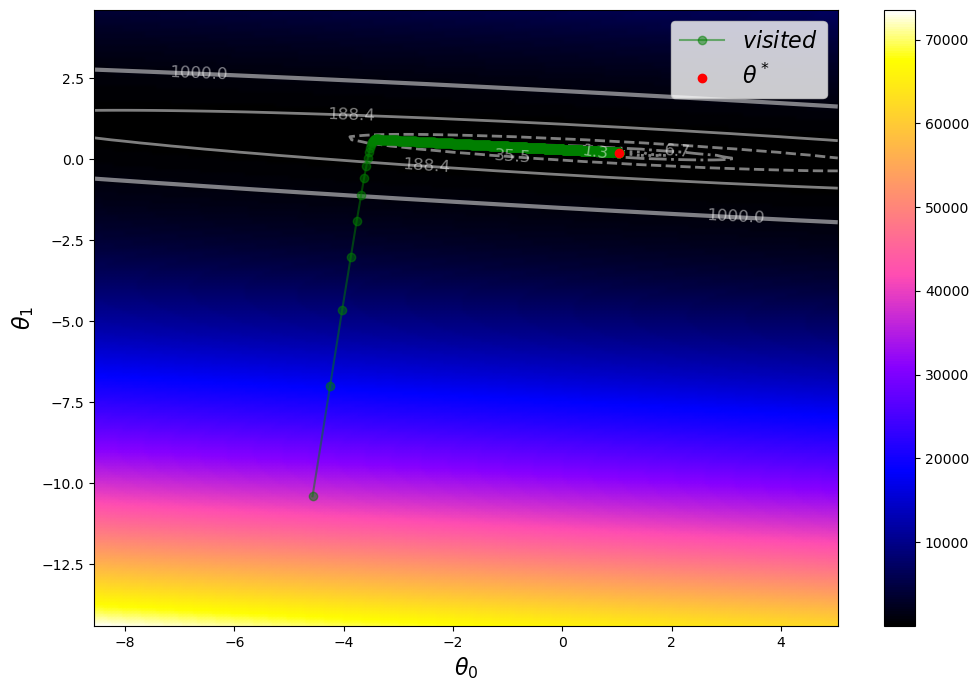

In [19]:
theta_visited = np.array(theta_list)  # numpy array of values of theta obtained through gradient descent (be careful about the expected shape)

# YOUR CODE HERE
if theta_visited.shape[1] != 2:
    theta_visited = theta_visited.reshape(-1, 2)  

theta_0 = 57/55
theta_1 = 23/110

# see above how this is plotted
plot_contour_2d_solution_space(mse,
                               theta_visited=theta_visited,
                               theta_star=np.array([[theta_0], [theta_1]]));

#### Question 3

Plot the norm of the gradient.

*Hint*: You simply have to compute its norm in the following function.

To test your work, you can make use of `dataframe_grad` provided earlier (see subsequent cell). How do you interpret it?

In [20]:
def plot_gradient(df_gradient: pd.DataFrame):
    df = df_gradient.copy()  # make an alias
    # Put the norm of the gradient at each iteration in a column named "norm"
    df['norm'] = np.sqrt(df['grad1']**2 + df['grad2']**2)

    # YOUR CODE HERE
    #raise NotImplementedError()

    ax = df.norm.plot(loglog=True, figsize=(16, 8))

    ax.set_title(r"Evolution of $||\nabla_{\theta} E(\theta)||_2$", fontsize=16)
    ax.set_xlabel("Iteration number", fontsize=16)
    ax.set_ylabel(r"Norm of $\nabla_{\theta} E(\theta)$", fontsize=16);

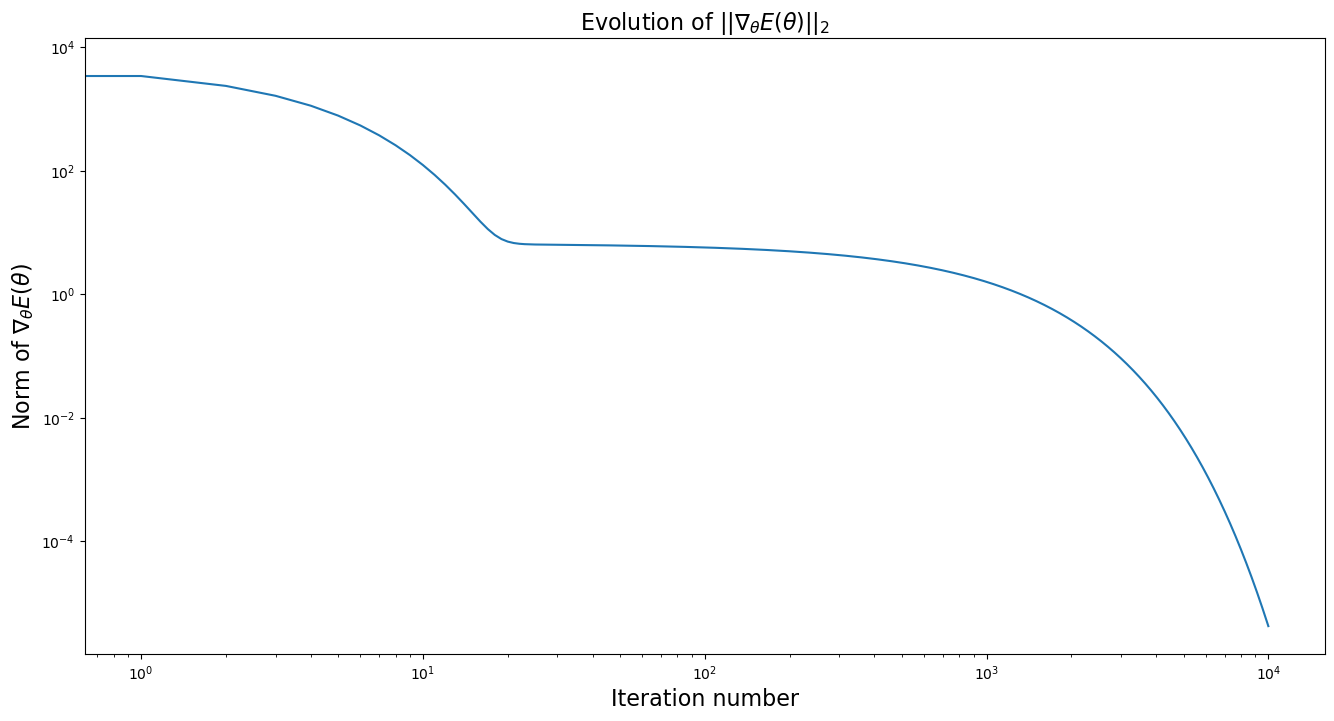

In [21]:
plot_gradient(dataframe_grad)

#### Question 4

Let's wrap up to the three first questions.

In [22]:
# Try with different values of eta (and optionally theta) IN SEPARATE CODE CELLS
def display_theta_visited_norm(eta=0.000001, theta=np.array([[7],[2]]), max_iteration=10000):
    ## Call your solution to Question 1 here to perform gradient descent.
    grad_list, theta_list = gradient_descent(X, y, eta)
    # YOUR CODE HERE
    #raise NotImplementedError()

    # Use the same procedure as previously:
    df_grad = pd.DataFrame(grad_list, columns=["grad1", "grad2"])
    df_theta = pd.DataFrame(theta_list, columns=["theta1", "theta2"])

    ## Use your solution to Question 2 here
    theta_visited = np.array(theta_list)
    # YOUR CODE HERE
    if theta_visited.shape[1] != 2:
        theta_visited = theta_visited.reshape(-1, 2)  
    
    theta_0 = 57/55
    theta_1 = 23/110

    # see above how this is plotted
    plot_contour_2d_solution_space(mse,
                                   theta_visited=theta_visited,
                                   theta_star=np.array([[theta_0], [theta_1]]))
    plt.show()
    ## Use your solution to Question 3 here (nothing to do, everything is already implemented in plot_gradient): pd.DataFrame
    # Computing the norm
    plot_gradient(df_grad)
    plt.show()

Let's restart the optimization using a different *learning rate* $\eta$.

What do you observe for a small $\eta$?

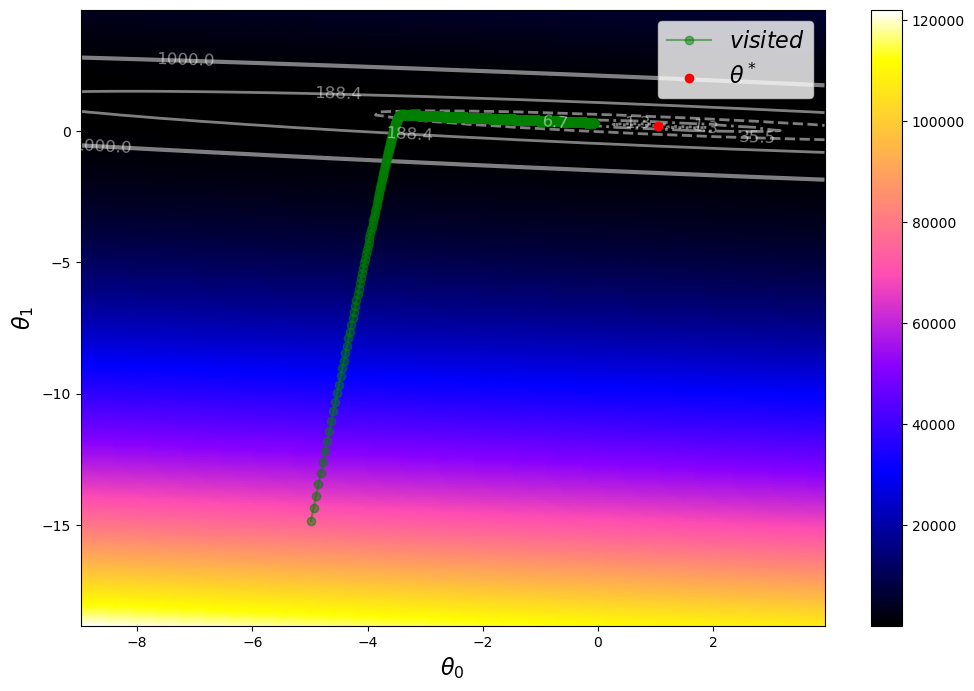

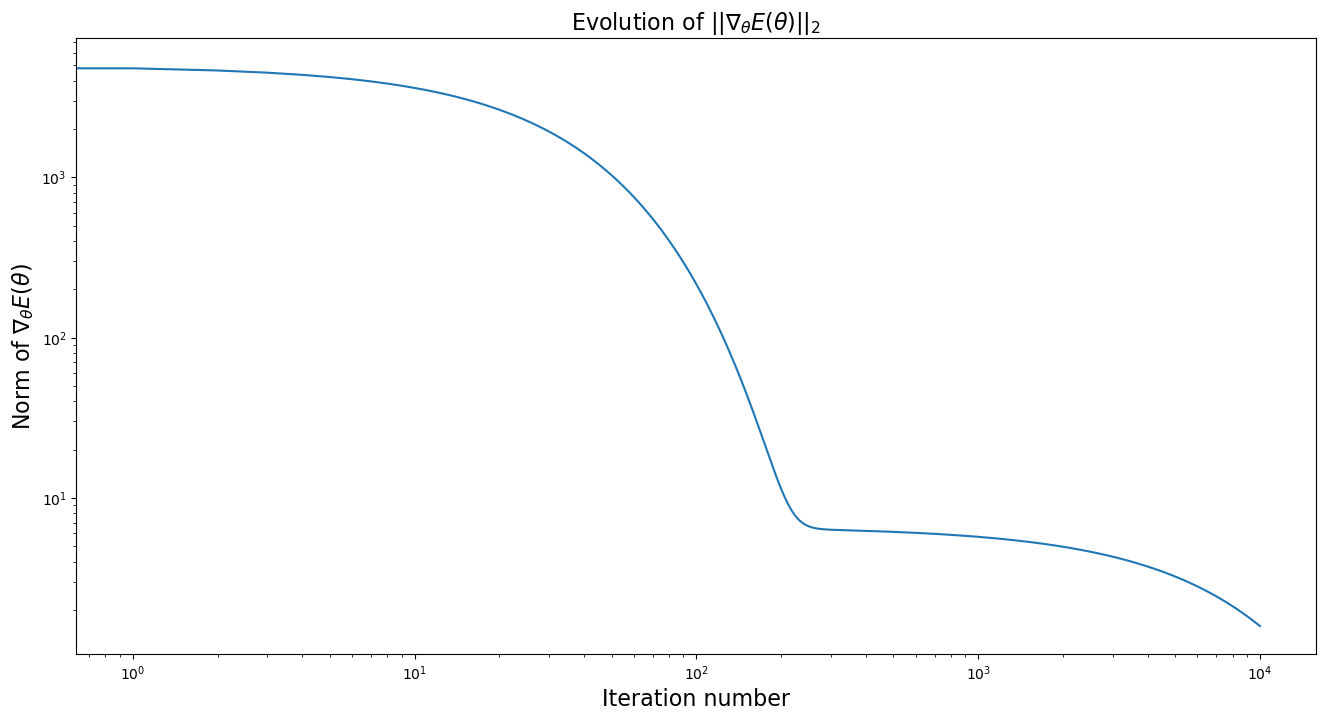

In [23]:
display_theta_visited_norm(0.0001, theta=np.array([[7],[2]]), max_iteration=10000)
# YOUR CODE HERE
#raise NotImplementedError()

YOUR ANSWER HERE

Eta is the learning rate thus we observe that when it's too small there is not enough iterations for the visited points to reach the $\theta^*$.

What do you observe for a large $\eta$?

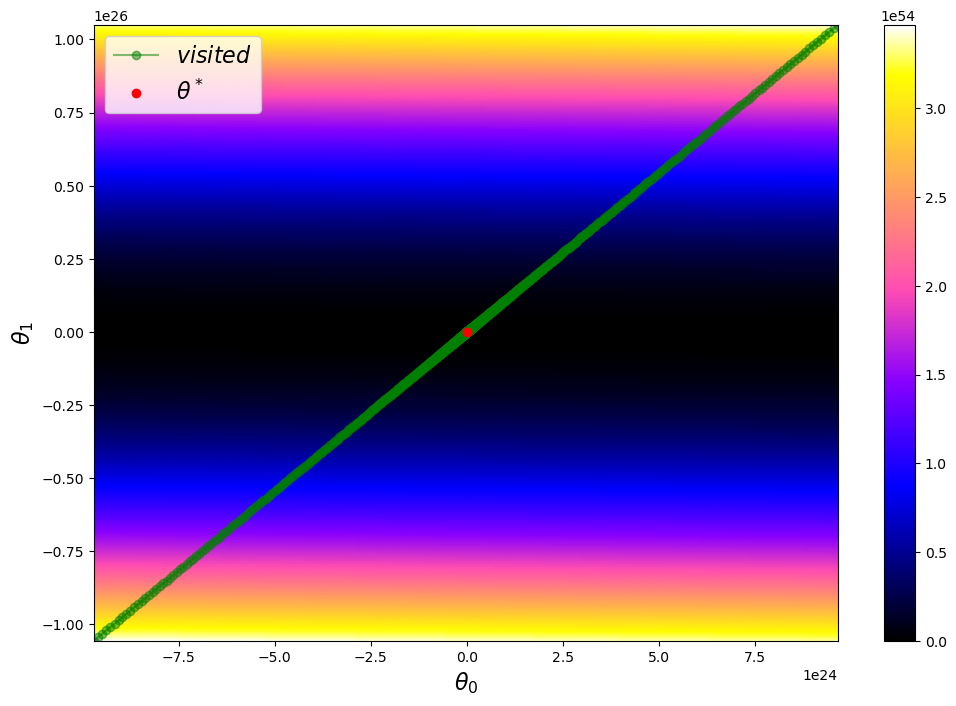

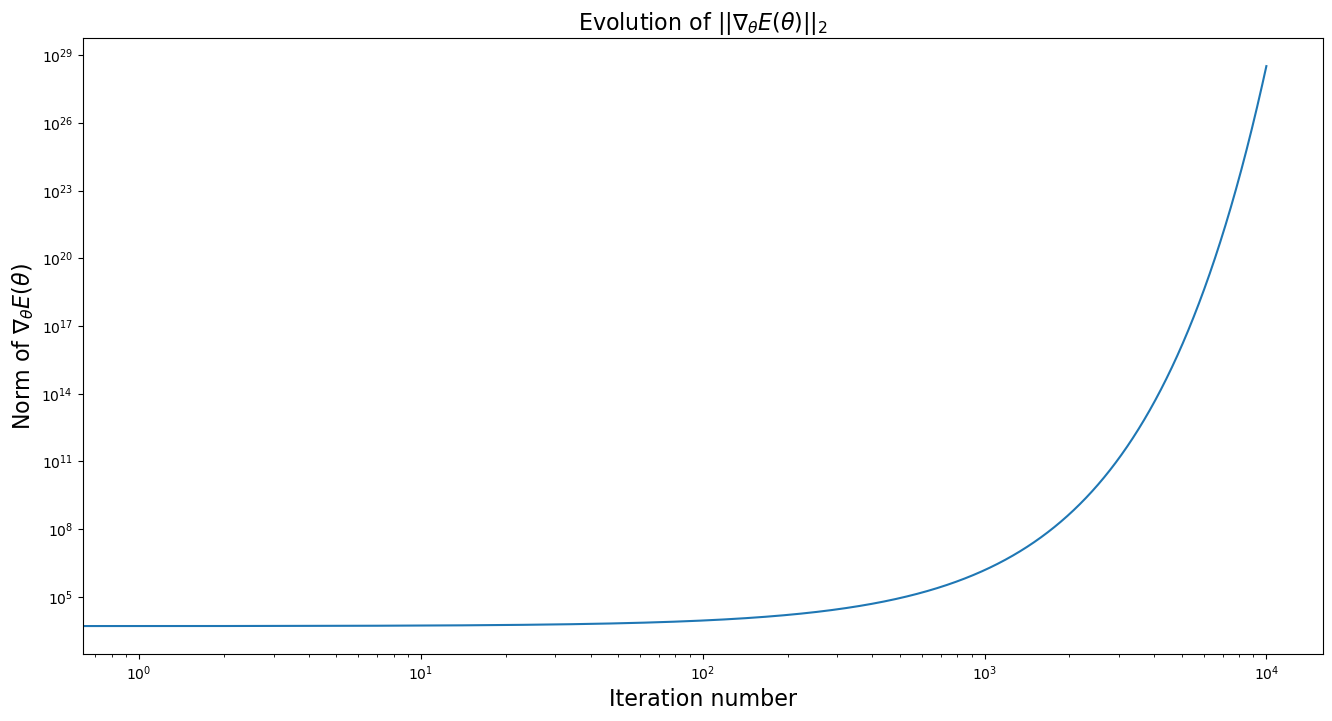

In [24]:
display_theta_visited_norm(0.0065)
# YOUR CODE HERE
#raise NotImplementedError()

In-between (too small and too large value for $\eta$), you should find some value where something "strange" happens...

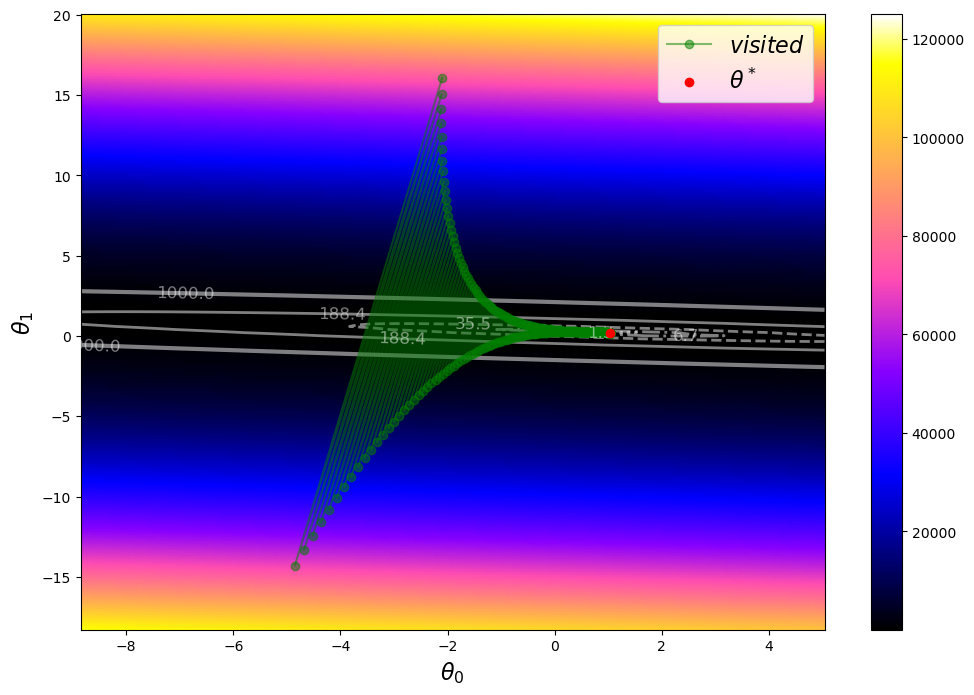

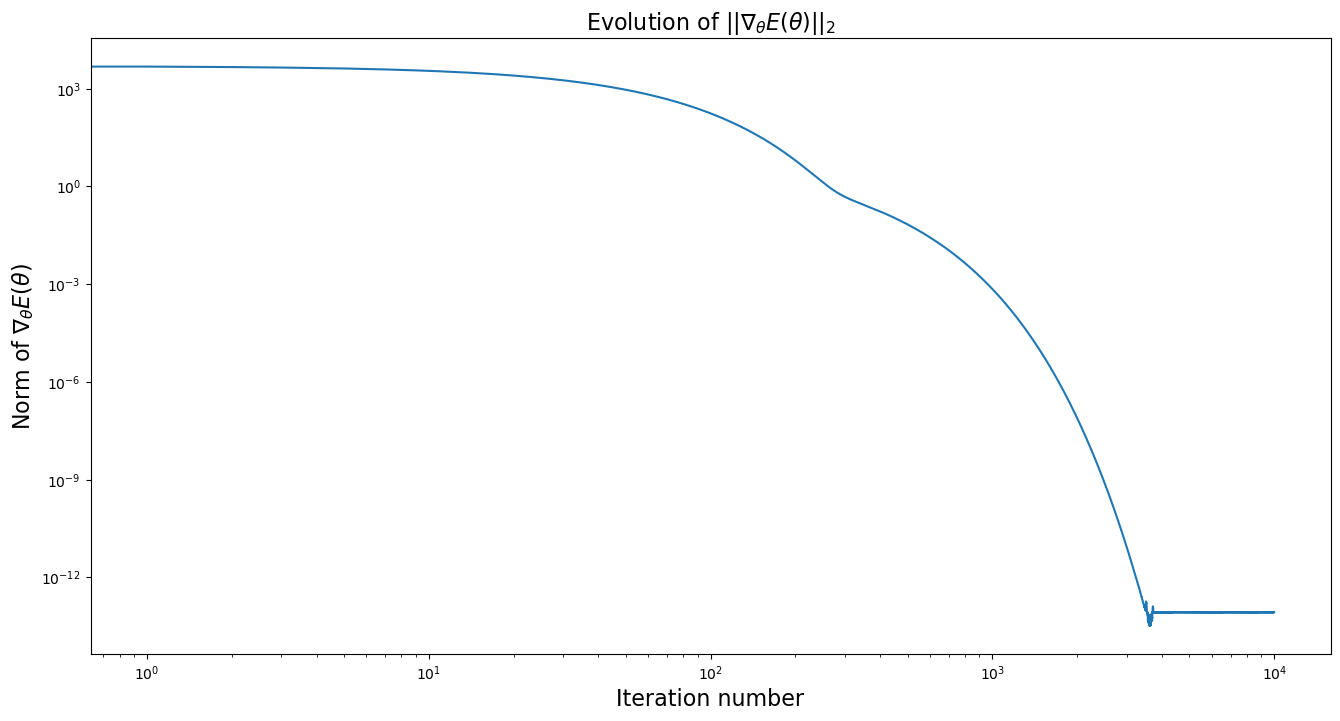

In [25]:
display_theta_visited_norm(0.006375)
# YOUR CODE HERE
#raise NotImplementedError()

YOUR ANSWER HERE

In the case when $\eta$ is too large we observe that the norm of the gradient diverges, when it should be converging to 0 for it to mean that the points are reaching $\theta*$.

YOUR ANSWER HERE

An example of a strange case is for an eta a bit lower the largest eta = 0.0065. We observe that the points oscillate and then suddenly start to converge.
It looks like it is not converging to zero at first but it ends up converging.


## Linear regression with Scikit Learn

Let's play with the Scikit Learn implementation of linear regression.
The official documentation is there: https://scikit-learn.org/stable/modules/linear_model.html

Use the `gen_1d_linear_regression_samples()` function (defined above) to generate a dataset and `plot_1d_regression_samples()` to plot it.

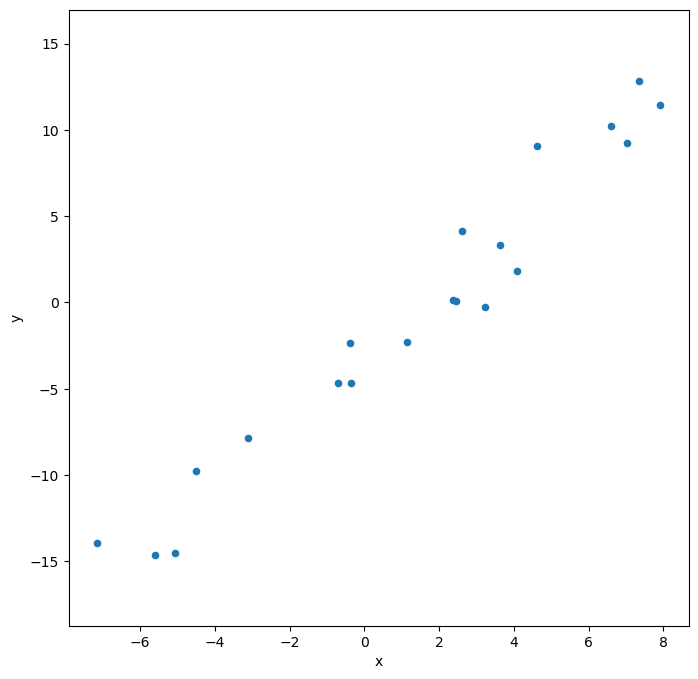

In [26]:
df = gen_1d_linear_regression_samples()

plot_1d_regression_samples(df)

Once the dataset is ready, let's make the regressor and train it with the following code:

In [27]:
linear_model = sklearn.linear_model.LinearRegression()

linear_model.fit(df[['x']], df[['y']])

LinearRegression()

This is equivalent to your function `gradient descent`. The `linear_model` object contains, among others, the final parameters (similar to `theta_list[-1]`).

The following cell plots the learned model (the red dashed line) and the dataset $\mathcal{D}$ (blue points).

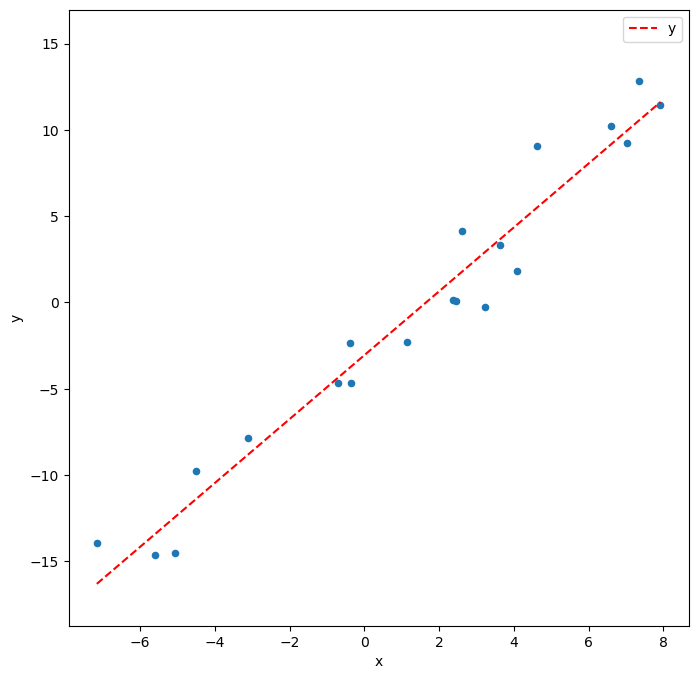

In [28]:
plot_1d_regression_samples(df, model=linear_model)

### Exercise 4

#### Question 1

What are the optimal parameters $\theta_0$ (intercept) and $\theta_1$ obtained? Put them in `intercept` and `slope` **as floats**.
(Note: there are attributes to the `LinearRegression` class which provide them - you should probably check the documentation linked above).

In [29]:
intercept = linear_model.intercept_[0]  # TO UNCOMMENT
slope = linear_model.coef_[0][0] # TO UNCOMMENT
# YOUR CODE HERE
#raise NotImplementedError()
print("Model intercept:", intercept)
print("Model slope:    ", slope)

Model intercept: -3.057330296869389
Model slope:     1.85155673828059


#### Question 2

Write the mathematical definition of the oracle (the data generating mechanism, see above) and your model.

Implement both as a function of X and plot it.

YOUR ANSWER HERE

The oracle represents the true data-generating function, which is typically a linear function with some noise. 

If we assume the oracle is of the form : 
$
y = \theta_0 + \theta_1 x + \epsilon
$

where $\epsilon$ is some noise and $\epsilon$ ~ $N(0,1.5)$

We then substitute with the approximate expected values by the model. The oracle is : $ y = 2x - 3 + \epsilon $

We could approximate the oracle to : $
y = \theta_0 + \theta_1 x
$

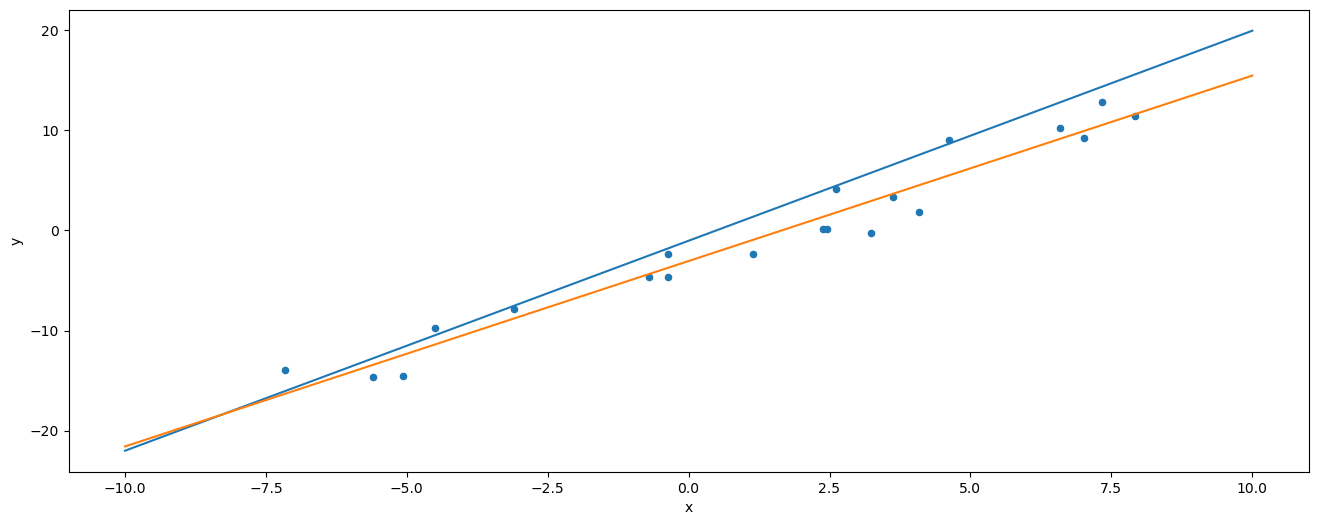

In [30]:
def f(X):
    # YOUR CODE HERE
    return -3 + 2 * X + np.random.normal(scale=1.5, size=X.shape)

def f_hat(X):
    # YOUR CODE HERE
    return intercept + slope * X

ax = df.plot.scatter(x='x', y='y', figsize=(16, 6))

X = np.array([-10, 10])
ax.plot(X, f(X))
ax.plot(X, f_hat(X));

#### Question 3

Use the `model.predict()` function to guess the class of the following points in a *vectorized* way (i.e. applying the `predict` method on an array, and returning and an array); put the result in `linear_predictions`:

$$x_{p1} = -2, \quad x_{p2} = 2, \quad x_{p3} = 6$$

In [31]:
predictions = pd.DataFrame({'x':[-2, 2, 6]})
linear_predictions = linear_model.predict(predictions) # TO UNCOMMENT
# YOUR CODE HERE
linear_predictions
#raise NotImplementedError()

array([[-6.76044377],
       [ 0.64578318],
       [ 8.05201013]])

## Polynomial regression

It is a common practice to use linear models trained on nonlinear transformations of the input data in machine learning. This approach maintains the generally fast performance of linear methods, while allowing them to fit a much wider range of data.

For instance, a linear model can be extended by making polynomial features from the coefficients. Linear model in exercises 1 and 2 looks like this (one-dimensional data):

$$f_{\theta}(x) = \theta_0 + \theta_1 x$$

If we want to fit a quadratic curve to the data instead of a line, we can combine the features in second-order polynomials, so that the model looks like this:

$$f_{\theta}(x) = \theta_0 + \theta_1 x + \theta_2 x^2$$

This is still a linear model: to illustrate this, we can create a new variable

$$z = [x, x^2]$$

With this re-labeling of the data, our problem can be written

$$f_{\theta}(x) = \theta_0 + \theta_1 z_1 + \theta_2 z_2$$

The resulting polynomial regression is in the same class of linear models we'd considered above (i.e. the model is linear in $\theta$) and can be solved by the same techniques. Thus the linear model has the flexibility to fit a much broader range of data.

### Exercise 5

#### Question 1

Use the previous equations to compute **by hand** (i.e. on a sheet of paper) the optimal parameters $\theta_1$ and $\theta_2$ of the model $y = \theta_1 x + \theta_1 x^2$ to best fit the following dataset (of four examples):

$$\mathcal{D} = \left\{
\begin{pmatrix} 1 \\ 0 \end{pmatrix},
\begin{pmatrix} 2 \\ 2 \end{pmatrix},
\begin{pmatrix} 3 \\ 3 \end{pmatrix},
\begin{pmatrix} 4 \\ 3.5 \end{pmatrix},
\begin{pmatrix} 5 \\ 3.7 \end{pmatrix}
\right\}.$$

YOUR ANSWER HERE

We define the design matrix $X$ using the features $x$ and $x^2$ :
$
X =
\begin{pmatrix}
1 & 1^2 \\
2 & 2^2 \\
3 & 3^2 \\
4 & 4^2 \\
5 & 5^2
\end{pmatrix}
$=$
\begin{pmatrix}
1 & 1 \\
2 & 4 \\
3 & 9 \\
4 & 16 \\
5 & 25
\end{pmatrix}
$ The target values are $
y =
\begin{pmatrix}
0 \\
2 \\
3 \\
3.5 \\
3.7
\end{pmatrix}
$

Let's compute the following :

$
X^T = \begin{pmatrix} 
1 & 2 & 3 & 4 & 5 \\ 
1 & 4 & 9 & 16 & 25
\end{pmatrix}
$ 

$
X^T X = \begin{pmatrix} 
55 & 225 \\ 
225 & 979 
\end{pmatrix}
$

$
(X^T X)^{-1} = \frac{1}{3220} \begin{pmatrix} 
979 & -225\\ 
-225 & 55
\end{pmatrix}
$

Then we find : $\theta = (X^TX)^{-1}X^Ty = \frac{1}{3220} \begin{pmatrix} 
3257\\ 
-145
\end{pmatrix}
$

We thus found $\theta_1$ = $\frac{3257}{3220}$ and $\theta_2$ = $\frac{-145}{3220}$

You can (optionnally) check your results using `numpy`. See e.g. `@`, `np.dot`, `np.matmul` and `np.linalg.inv`.

In [32]:
# YOUR CODE HERE
#raise NotImplementedError()

Let's plot these points:

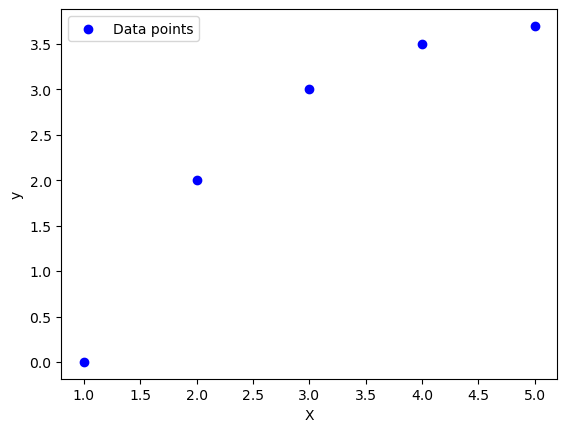

In [33]:
X = [1, 2, 3, 4, 5]
y = [0, 2, 3, 3.5, 3.7]

plot_ex4(X, y)

#### Question 2

Check graphically that the model you obtained fits the data well using the following cell (complete the first two lines).

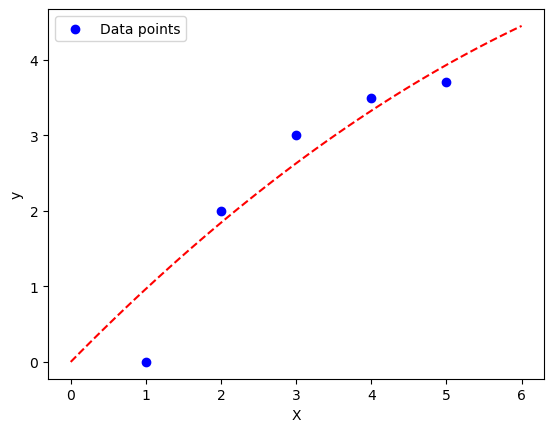

In [34]:
X = [1, 2, 3, 4, 5]
y = [0, 2, 3, 3.5, 3.7]

theta_1 = 3257/3220  # <- TO UNCOMMENT
theta_2 = -145/3220  # <- TO UNCOMMENT
# YOUR CODE HERE

plot_ex4(X, y, theta_1, theta_2)

This doesn't seem very good: why?

YOUR ANSWER HERE

The regression seems to not exactly fit the data set probably because a quadratic model is not the best fit in this case. 

## Polynomial regression with Scikit Learn

Let's play with the Scikit Learn implementation of polynomial regression.
The official documentation is there: https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions

First we generate the dataset (see `gen_1d_polynomial_regression_samples` defined above), plot it, instantiate a regressor and train it with the following code:

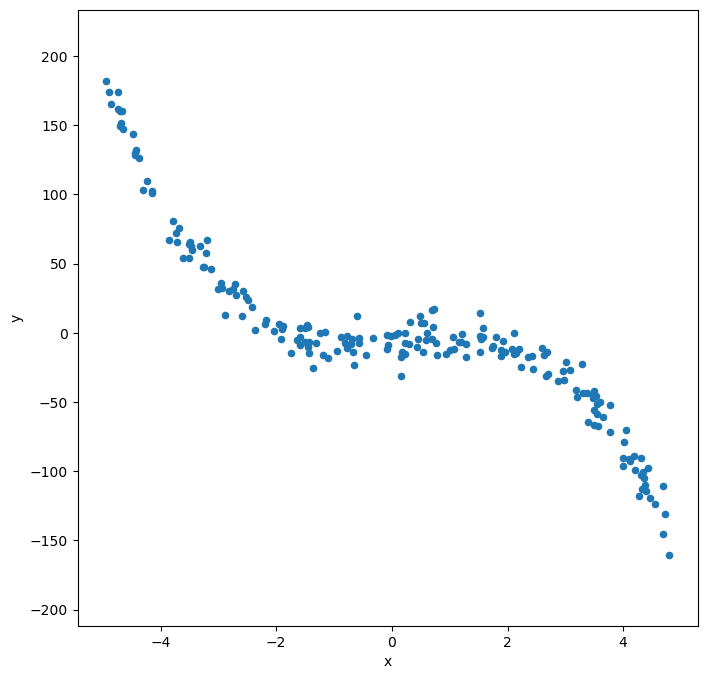

In [35]:
df = gen_1d_polynomial_regression_samples(n_samples=200)
plot_1d_regression_samples(df)

In [36]:
polynomial_features = sklearn.preprocessing.PolynomialFeatures(degree=3)  # In Q. 4, try with degree = 1, 4 and 15

In `sklearn.preprocessing.PolynomialFeatures()`, `degree` is the degree of the polynomal function.

In [37]:
def learn_poly_model(poly_features: sklearn.preprocessing.PolynomialFeatures):
    # no intercept in the LinearRegression since PolynomialFeatures includes a "bias"
    # see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
    linear_regression = sklearn.linear_model.LinearRegression(fit_intercept=False)

    model = sklearn.pipeline.Pipeline([("polynomial_features", polynomial_features),
                                       ("linear_regression", linear_regression)])

    model.fit(df[['x']], df[['y']])
    return linear_regression, model

In [38]:
linear_regression, model = learn_poly_model(polynomial_features)

The following cell plots the learned model (the red dashed line) and the dataset $\mathcal{D}$ (blue points).

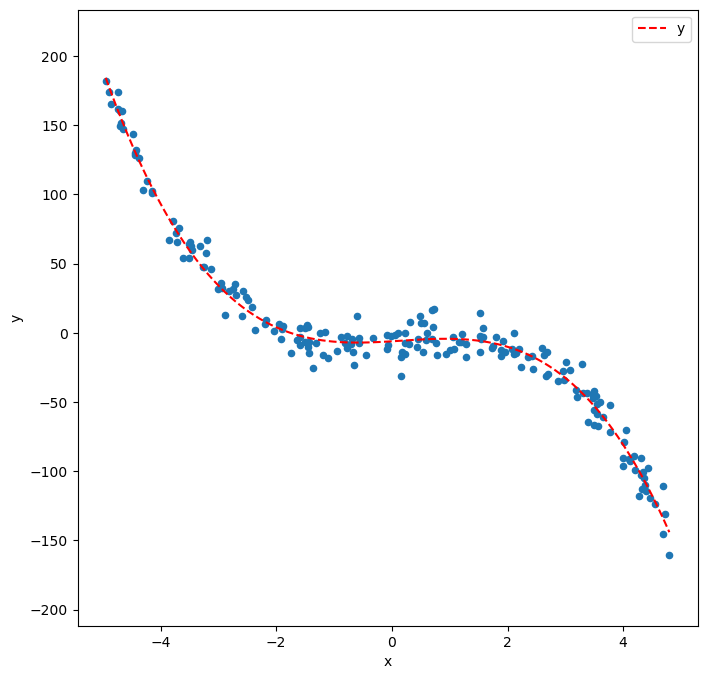

In [39]:
plot_1d_regression_samples(df, model=model)

### Exercise 6

#### Question 1

What are the optimal parameters $\theta_0, \theta_1, \theta_2, \theta_3$ obtained (**as floats**)? Check the attributes of `linear_regression`. Remember from above that a bias term (1) is included in the PolynomialFeatures but we did not allow (which would be redundant) LinearRegression to fit an intercept term.

In [40]:
theta_0 = linear_regression.coef_[0][0]
theta_1 = linear_regression.coef_[0][1]
theta_2 = linear_regression.coef_[0][2]
theta_3 = linear_regression.coef_[0][3]

# YOUR CODE HERE
#raise NotImplementedError()

print("theta_0 (intercept):", linear_regression.coef_[0][0])
print("theta_1:            ", linear_regression.coef_[0][1])
print("theta_2:            ", linear_regression.coef_[0][2])
print("theta_3:            ", linear_regression.coef_[0][3])

theta_0 (intercept): -6.078496424988426
theta_1:             2.5511610732503596
theta_2:             0.770236566832134
theta_3:             -1.5198885606495605


#### Question 2

Write the mathematical definition of the generated data (see above) and your model. Plot the result.

YOUR ANSWER HERE

The dataset was generated based on a cubic polynomial function :  $
f(x) = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 + \epsilon
$

where $\epsilon$ represents random noise, and $\theta_0$, $\theta_1$, $\theta_2$, $\theta_3$ are the parameters learned by the model.  

After training, the model identified the following polynomial as the best fit for the data:  $
\hat{f}(x) = -3.23 + 1.34x + 0.71x^2 - 1.47x^3
$

This equation describes the function that the model approximated from the given dataset.


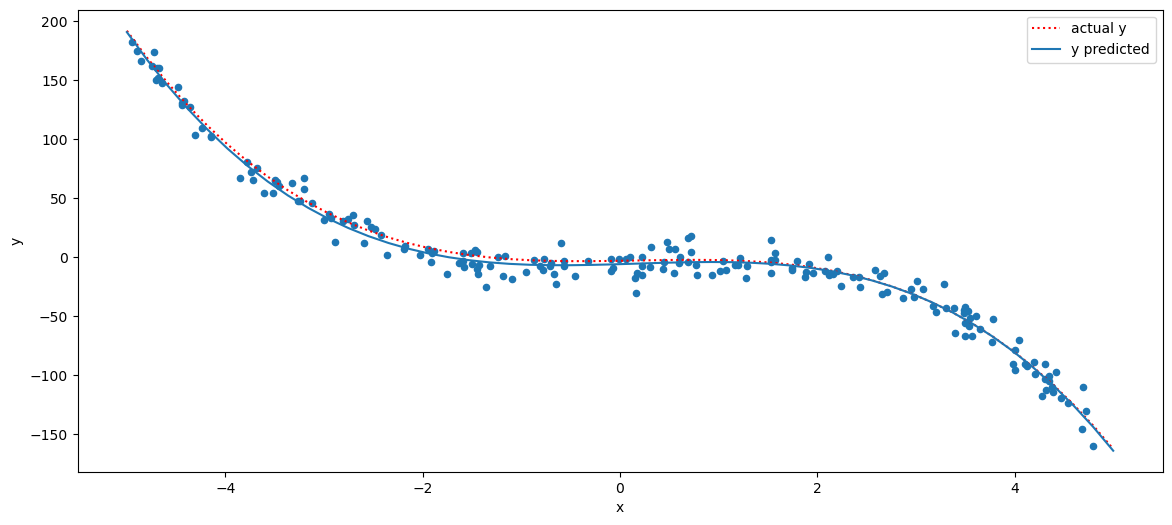

In [47]:
x = np.linspace(-5., 5., 50)
x_df = pd.DataFrame(x, columns=['x']) 
y_hat =  model.predict(x_df)  # <- TO UNCOMMENT: this is sklearn's prediction
y = -3.23 + 1.34*x + 0.71*x**2 - 1.47*x**3  # <- TO UNCOMMENT: this is the equation you found by looking above

# YOUR CODE HERE

x=x.flatten()
y=y.flatten()
y_pred=y_hat.flatten()

ax = df.plot.scatter(x='x', y='y', figsize=(14, 6))

df_model = pd.DataFrame(np.array([x, y, y_pred]).T, columns=['x', 'y', 'y_pred'])

df_model.plot(x='x', y='y', style=':r', label='actual y', ax=ax)
df_model.plot(x='x', y='y_pred', label='y predicted', ax=ax);

#### Question 3

Use the `model.predict()` function to infer the `y` value of the following points:

$$x_{p1} = 1, \quad x_{p2} = 2, \quad x_{p3} = 6$$

Put the result in `predictions`.

In [48]:
predictions = pd.DataFrame({'x': [1, 2, 6]})
# YOUR CODE HERE
prediction_model = model.predict(predictions)
prediction_model

array([[  -4.27698735],
       [ -10.0543365 ],
       [-291.33894268]])

#### Question 4

In `sklearn.preprocessing.PolynomialFeatures()`, change the value of `degree` and describe what happen on the plot (use e.g. 1 and 15 - possibly with fewer observations).
What is the name of the observed phenomenons?

YOUR ANSWER HERE

When degree 1, the model fits a simple linear function, leading to underfitting, as it fails to capture data complexity.


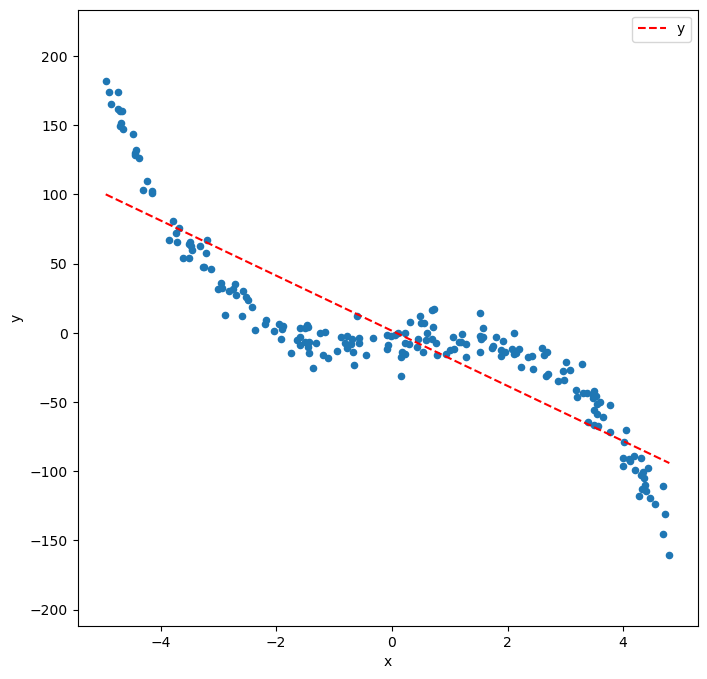

In [50]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_features = PolynomialFeatures(degree=1)
# YOUR CODE HERE

linear_regression, model = learn_poly_model(polynomial_features)

plot_1d_regression_samples(df, model=model)

YOUR ANSWER HERE

When degree 15, the model becomes highly flexible, fitting noise rather than the true pattern, causing overfitting. This illustrates the bias-variance tradeoff.

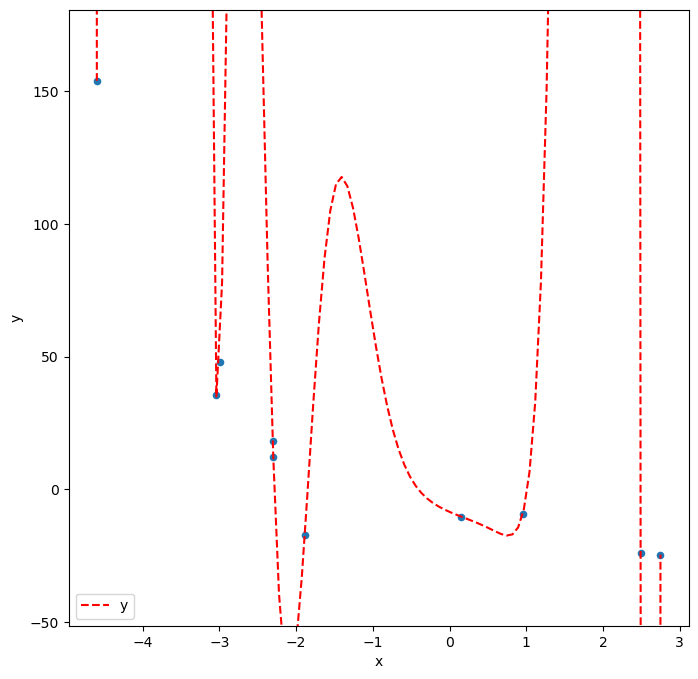

In [52]:
df = gen_1d_polynomial_regression_samples(n_samples=10)

from sklearn.preprocessing import PolynomialFeatures

polynomial_features = PolynomialFeatures(degree=15)  
# YOUR CODE HERE
#raise NotImplementedError()

linear_regression, model = learn_poly_model(polynomial_features)

plot_1d_regression_samples(df, model=model)

## CO2 Emission Forecast (bonus)

In this exercise, you will forecast 5 years of future CO2 emission from power generation using natural gas.

This exercise use a dataset taken from https://www.kaggle.com/berhag/co2-emission-forecast-with-python-seasonal-arima.

This public dataset contain monthly carbon dioxide emissions from electricity generation. The dataset includes CO2 emissions starting January 1973 to July 2016.

In [ ]:
filepath = "https://raw.githubusercontent.com/jeremiedecock/polytechnique-cse204-2018/master/natural_gas_co2_emissions_for_electric_power_sector.csv"

df = pd.read_csv(filepath,
                 parse_dates=[0])
df.head()

In [ ]:
df.plot(x='date', y='co2_emissions', figsize=(15,10), title='Natural Gas Electric Power Sector CO2 Emissions');

### Exercise 7 (bonus)

Implement a model to make predictions on this dataset.
Use polynomial basis functions plus two sinusoids to handle the seasonality of this time series: $\sin(\frac{2 \pi}{12} x)$ and $\cos\left(\frac{2 \pi}{12} x \right)$. This signal contains a periodic component of 12 time steps (**where one time step equals to one month**).

We use both $\sin$ and $\cos$ to avoid unaligned phases with the time series. Alternatively, we could use only $\sin\left(\frac{2 \pi}{12} (x + \phi)\right)$ or $\cos\left(\frac{2 \pi}{12} (x + \phi)\right)$ as long as $\phi$ is properly set: $\phi = \pi / 2$ in the first case and $\phi = 0$ in the second one.

What are the limitations of this model?

YOUR ANSWER HERE

In [ ]:
# X = increments by 1 for each month, see `index` or `date`
# y = co2 emissions, see `co2_emissions`
# Add column of 1, X², X³, ... Concatenate and create a pandas DataFrame

# YOUR CODE HERE
raise NotImplementedError()
df_Z = pd.DataFrame(Z, columns=['intercept', 'z', 'z2', 'z3', 'sin', 'cos'])
df_Z.tail()

With the following plot, we check that the seasonality of the time series is correctly aligned with our sine and cosine bases:

In [ ]:
ax = df_Z.loc[:, ['sin', 'cos']].plot(figsize=(18,8))
ax.plot(y);

Then we make and fit the model:

In [ ]:
# model = ...
# model.fit(...)

# YOUR CODE HERE
raise NotImplementedError()

The following cell plots the learned model and the dataset $\mathcal{D}$ (blue points):

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))

# Compute the model's prediction
y_pred = model.predict(df_Z)
ax.plot(y_pred, label="Precicted y");

# Plot also the training points
ax.plot(y, label="Actual y")
ax.legend()
plt.show()

Then we use the model to (roughly) forecast the CO2 emission for the 5 next years:

In [ ]:
# [...]
# df_Z_forecast = ...
# model.predict(...)
# ax.plot(...)

# YOUR CODE HERE
raise NotImplementedError()